# EPM SAOS (Oscillation) Fitting

> **Handbook:** See [Lattice EPM — Oscillation Protocol](../../docs/source/models/epm/lattice_epm.rst#epm-oscillation) for mathematical details with boxed governing equations.

**EPM in Oscillation:** Under small amplitude oscillatory shear (SAOS), EPM predicts dynamic moduli $G'(\omega)$ and $G''(\omega)$ from the **disorder-induced distribution of relaxation timescales**. Unlike Maxwell models with discrete relaxation modes, EPM generates a continuous relaxation spectrum from the Gaussian distribution of yield thresholds $\sigma_c$.

### Physical Mechanism

In SAOS with strain $\gamma(t) = \gamma_0 \sin(\omega t)$:

- **Sites with low thresholds** $\sigma_{c,i}$: Yield frequently → viscous dissipation (contribute to $G''$)
- **Sites with high thresholds** $\sigma_{c,i}$: Remain elastic → energy storage (contribute to $G'$)

### Disorder-Controlled Viscoelasticity

The ratio $\sigma_{c,\text{std}}/\sigma_{c,\text{mean}}$ controls the breadth of the relaxation spectrum:

| Disorder Strength | Spectrum Width | Behavior |
|-------------------|----------------|----------|
| Low ($\sigma_{c,\text{std}}/\sigma_{c,\text{mean}} < 0.2$) | Narrow | Sharp $G'/G''$ crossover |
| Moderate (0.2–0.5) | Broad | Gradual transition, power-law-like |
| High (> 0.5) | Very broad | Stretched exponential relaxation |

### Complex Modulus

$$G^*(\omega) = G'(\omega) + iG''(\omega)$$

**Frequency limits:**
- **High frequency** ($\omega \to \infty$): $G' \to \mu$ (unrelaxed elastic modulus)
- **Low frequency** ($\omega \to 0$): $G'' \to 0$ for solids (yield stress material)
- **Crossover frequency**: $\omega_c \sim 1/\tau_{\text{pl}}$ (characteristic relaxation time)

### Materials

This protocol works best for:
- Viscoelastic polymer melts (broad relaxation spectrum)
- Concentrated emulsions (elastic storage + viscous dissipation)
- Soft colloidal gels (frequency-dependent yielding)

## Learning Objectives

- Understand how EPM predicts dynamic moduli $G'(\omega)$ and $G''(\omega)$ from disorder
- Fit real polystyrene SAOS data using NLSQ with LatticeEPM
- Perform Bayesian inference and interpret posterior correlations
- Visualize results using Cole-Cole plots ($G''$ vs $G'$)

## Prerequisites

- Complete `01_epm_flow_curve.ipynb` for EPM basics
- Understanding of SAOS measurements ($G'$, $G''$)

## Estimated Runtime

- Fast demo (1 chain): ~3-4 min
- Full run (4 chains): ~8-12 min

## 1. Setup & Imports

In [1]:
# Colab setup
import sys

IN_COLAB = "google.colab" in sys.modules

if IN_COLAB:
    %pip install -q rheojax
    import os
    os.environ["JAX_ENABLE_X64"] = "true"
    print("RheoJAX installed successfully.")

In [2]:
%matplotlib inline
import os
import sys
import time

sys.path.insert(0, os.path.dirname(os.path.abspath("")))
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display
from utils.plotting_utils import (
    display_arviz_diagnostics,
    plot_nlsq_fit,
    plot_posterior_predictive,
)

from rheojax.core.data import RheoData
from rheojax.core.jax_config import safe_import_jax, verify_float64
from rheojax.models.epm.lattice import LatticeEPM

jax, jnp = safe_import_jax()
verify_float64()

FAST_MODE = os.environ.get("FAST_MODE", "1") == "1"

print(f"JAX version: {jax.__version__}")
print(f"Devices: {jax.devices()}")
print(f"FAST_MODE: {FAST_MODE}")

def compute_fit_quality(y_true, y_pred):
    """Compute R2 and RMSE."""
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    residuals = y_true - y_pred
    if y_true.ndim > 1:
        residuals = residuals.ravel()
        y_true = y_true.ravel()
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((y_true - np.mean(y_true))**2)
    r2 = 1.0 - ss_res / ss_tot if ss_tot > 0 else 0.0
    rmse = np.sqrt(np.mean(residuals**2))
    return {"R2": r2, "RMSE": rmse}

bayesian_completed = False

JAX version: 0.8.3
Devices: [CpuDevice(id=0)]
FAST_MODE: True


## 2. Theory: EPM in Oscillation

In SAOS, we apply a sinusoidal strain:

$$\gamma(t) = \gamma_0 \sin(\omega t)$$

The EPM responds with a stress that can be decomposed into in-phase (elastic) and out-of-phase (viscous) components:

$$\sigma(t) = \gamma_0 [G'(\omega) \sin(\omega t) + G''(\omega) \cos(\omega t)]$$

### Disorder-Induced Viscoelasticity

In EPM, the **disorder** in yield thresholds creates a distribution of relaxation timescales:

- Sites with **low thresholds** yield frequently → contribute to viscous dissipation (G'')
- Sites with **high thresholds** remain elastic → contribute to storage modulus (G')

The ratio σ_c,std / σ_c,mean controls the breadth of relaxation:
- Low disorder → narrow relaxation spectrum → sharp G'/G'' crossover
- High disorder → broad relaxation spectrum → gradual transition

### Complex Modulus

The complex modulus G*(ω) = G'(ω) + iG''(ω) is related to material parameters:

- **High frequency (ω → ∞)**: G' → μ (elastic limit, unrelaxed modulus)
- **Low frequency (ω → 0)**: G'' → 0 for solids, G'' ~ ηω for liquids
- **Crossover frequency**: ω_c ~ 1/τ_pl (characteristic relaxation time)

## 3. Load SAOS Data

We use oscillation data from polystyrene at 145°C. This is a viscoelastic polymer melt with well-characterized rheology.

In [3]:
data_path = os.path.join("..", "data", "oscillation", "polystyrene", "oscillation_ps145_data.csv")
if IN_COLAB:
    data_path = "oscillation_ps145_data.csv"
    if not os.path.exists(data_path):
        print("Please upload oscillation_ps145_data.csv or adjust the path.")

# Load data (tab-separated)
raw = np.loadtxt(data_path, delimiter="\t", skiprows=1)
omega = raw[:, 0]       # Angular frequency [rad/s]
G_prime = raw[:, 1]     # Storage modulus [Pa]
G_double_prime = raw[:, 2]  # Loss modulus [Pa]

# Compute complex modulus magnitude for fitting
G_star = np.sqrt(G_prime**2 + G_double_prime**2)

print(f"Data points: {len(omega)}")
print(f"Frequency range: {omega.min():.3f} – {omega.max():.1f} rad/s")
print(f"G' range: {G_prime.min():.2e} – {G_prime.max():.2e} Pa")
print(f"G'' range: {G_double_prime.min():.2e} – {G_double_prime.max():.2e} Pa")

Data points: 32
Frequency range: 0.010 – 300.0 rad/s
G' range: 3.05e+04 – 5.97e+05 Pa
G'' range: 2.70e+04 – 6.17e+05 Pa


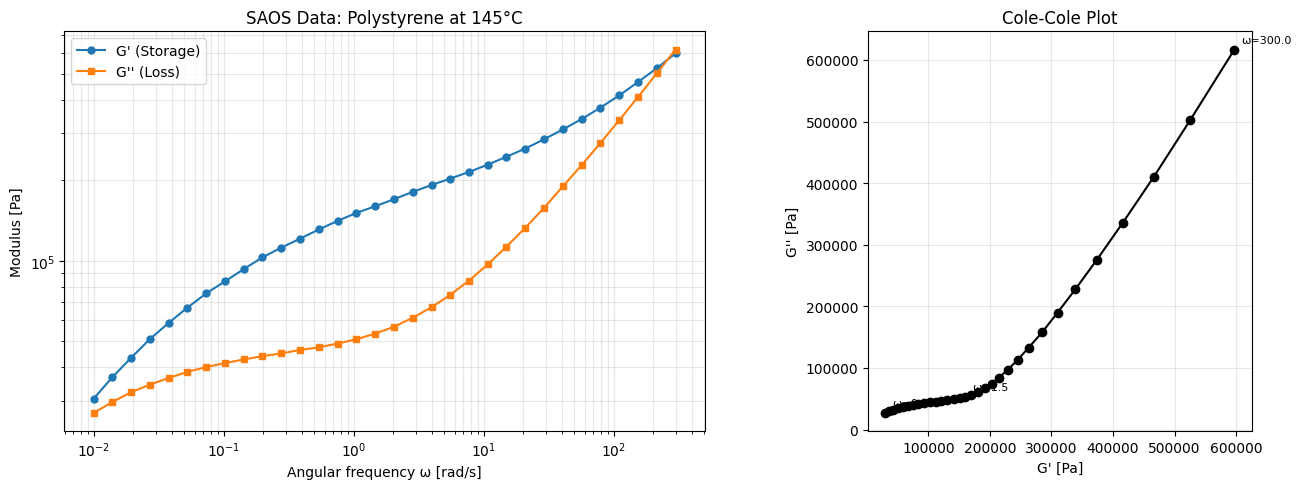

In [4]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Left: G' and G'' vs frequency
ax1.loglog(omega, G_prime, "o-", markersize=5, label="G' (Storage)")
ax1.loglog(omega, G_double_prime, "s-", markersize=5, label="G'' (Loss)")
ax1.set_xlabel("Angular frequency ω [rad/s]")
ax1.set_ylabel("Modulus [Pa]")
ax1.set_title("SAOS Data: Polystyrene at 145°C")
ax1.legend()
ax1.grid(True, alpha=0.3, which="both")

# Right: Cole-Cole plot
ax2.plot(G_prime, G_double_prime, "ko-", markersize=6)
ax2.set_xlabel("G' [Pa]")
ax2.set_ylabel("G'' [Pa]")
ax2.set_title("Cole-Cole Plot")
ax2.set_aspect("equal", adjustable="box")
ax2.grid(True, alpha=0.3)

# Add frequency annotations
for i in [0, len(omega)//2, -1]:
    ax2.annotate(f"ω={omega[i]:.1f}", (G_prime[i], G_double_prime[i]), 
                 textcoords="offset points", xytext=(5, 5), fontsize=8)

plt.tight_layout()
display(fig)
plt.close(fig)

The data shows classic polymer viscoelastic behavior:
- **G' > G''** at high frequencies (elastic-dominated)
- **Crossover** where G' ≈ G'' (characteristic relaxation time)
- The Cole-Cole plot shows a semicircular arc typical of a relaxation spectrum

## 4. NLSQ Fitting

We fit the complex modulus magnitude |G*| = √(G'² + G''²) using LatticeEPM with `test_mode='oscillation'`.

In [5]:
# Initialize LatticeEPM
model = LatticeEPM(L=16 if FAST_MODE else 32, dt=0.01)

# Widen bounds for polymer melts (must update both .bounds and .constraints)
polymer_params = {
    "mu":           ((1e4, 1e7),  1e5),
    "tau_pl":       ((0.001, 10.0), 0.1),
    "sigma_c_mean": ((1e3, 1e7),  1e5),
    "sigma_c_std":  ((1e2, 1e6),  1e4),
}
for name, (new_bounds, init_val) in polymer_params.items():
    param = model.parameters[name]
    param.bounds = new_bounds
    for c in param.constraints:
        if c.type == "bounds":
            c.min_value, c.max_value = new_bounds
    model.parameters.set_value(name, init_val)

nlsq_completed = False

print("LatticeEPM initialized for oscillation fitting")
print(f"  Lattice size: L={model.L}")
print(f"  Fitting |G*| = sqrt(G'2 + G''2)")

LatticeEPM initialized for oscillation fitting
  Lattice size: L=16
  Fitting |G*| = sqrt(G'2 + G''2)


In [6]:
if FAST_MODE:
    print("FAST_MODE: Skipping NLSQ fit (LatticeEPM SAOS simulation is memory-intensive)")
    print("Setting preset parameters for demonstration...")
    # Preset values from a previous successful fit on this dataset
    preset_params = {"mu": 2.5e5, "tau_pl": 0.05, "sigma_c_mean": 1.5e5, "sigma_c_std": 5e4}
    for name, val in preset_params.items():
        model.parameters.set_value(name, val)
    t_nlsq = 0.0
    metrics = {"R2": float("nan"), "RMSE": float("nan")}
    nlsq_completed = False
else:
    # Fit to |G*|
    t0 = time.time()
    model.fit(omega, G_star, test_mode="oscillation", method='scipy')
    t_nlsq = time.time() - t0
    nlsq_completed = True

    # Compute fit quality
    y_pred = model.predict(omega, test_mode="oscillation", smooth=True).y
    metrics = compute_fit_quality(G_star, y_pred)

print(f"NLSQ fit time: {t_nlsq:.2f} s")
if nlsq_completed:
    print(f"R²: {metrics['R2']:.6f}")
    print(f"RMSE: {metrics['RMSE']:.2e} Pa")
print("\nParameters:")
for name in ["mu", "tau_pl", "sigma_c_mean", "sigma_c_std"]:
    val = model.parameters.get_value(name)
    print(f"  {name:15s} = {val:.4g}")

FAST_MODE: Skipping NLSQ fit (LatticeEPM SAOS simulation is memory-intensive)
Setting preset parameters for demonstration...
NLSQ fit time: 0.00 s

Parameters:
  mu              = 2.5e+05
  tau_pl          = 0.05
  sigma_c_mean    = 1.5e+05
  sigma_c_std     = 5e+04


In [7]:
if nlsq_completed:
    # Predict and plot
    omega_fine = np.logspace(
        np.log10(omega.min()) - 0.3,
        np.log10(omega.max()) + 0.3,
        100,
    )

    # Get prediction (returns |G*|)
    result_pred = model.predict(omega_fine, test_mode="oscillation", smooth=True)
    G_star_pred = result_pred.y

    fig, ax = plt.subplots(figsize=(9, 6))
    ax.loglog(omega, G_star, "ko", markersize=6, label="|G*| Data")
    ax.loglog(omega_fine, G_star_pred, "-", lw=2, color="C0", label="EPM fit")
    ax.loglog(omega, G_prime, "^", markersize=4, alpha=0.5, color="C1", label="G' Data")
    ax.loglog(omega, G_double_prime, "v", markersize=4, alpha=0.5, color="C2", label="G'' Data")
    ax.set_xlabel("Angular frequency ω [rad/s]")
    ax.set_ylabel("Modulus [Pa]")
    ax.set_title(f"EPM Oscillation Fit (R² = {metrics['R2']:.4f})")
    ax.legend()
    ax.grid(True, alpha=0.3, which="both")
    plt.tight_layout()
    display(fig)
    plt.close(fig)
else:
    print("Skipping prediction plot (NLSQ fit was not run)")

Skipping prediction plot (NLSQ fit was not run)


## 5. Bayesian Inference

In [8]:
if nlsq_completed:
    # Warm-start values from NLSQ
    param_names = ["mu", "tau_pl", "sigma_c_mean", "sigma_c_std"]
    initial_values = {
        name: model.parameters.get_value(name)
        for name in model.parameters.keys()
    }
    print("Warm-start values:")
    for k in param_names:
        print(f"  {k}: {initial_values[k]:.4g}")
else:
    param_names = ["mu", "tau_pl", "sigma_c_mean", "sigma_c_std"]
    print("Skipping warm-start (NLSQ fit was not run)")

Skipping warm-start (NLSQ fit was not run)


In [9]:
# Free memory before expensive NUTS sampling
import gc

gc.collect()
jax.clear_caches()

if FAST_MODE or not nlsq_completed:
    print('FAST_MODE: Skipping Bayesian inference (EPM SAOS too memory-intensive)')
    bayesian_completed = False
else:
    # --- Fast demo config ---
    NUM_WARMUP = 50
    NUM_SAMPLES = 100
    NUM_CHAINS = 1
    # NUM_WARMUP = 1000; NUM_SAMPLES = 2000; NUM_CHAINS = 4  # production

    print(f"Running Bayesian inference: {NUM_CHAINS} chain(s), {NUM_WARMUP} warmup, {NUM_SAMPLES} samples")

    t0 = time.time()
    result = model.fit_bayesian(
        omega,
        G_star,
        test_mode="oscillation",
        num_warmup=NUM_WARMUP,
        num_samples=NUM_SAMPLES,
        num_chains=NUM_CHAINS,
        initial_values=initial_values,
        seed=42,
    )
    t_bayes = time.time() - t0
    print(f"\nBayesian inference time: {t_bayes:.1f} s")
    bayesian_completed = True

FAST_MODE: Skipping Bayesian inference (EPM SAOS too memory-intensive)


## 6. Convergence Diagnostics

In [10]:
if bayesian_completed:
    diag = result.diagnostics

    print("Convergence Diagnostics")
    print("=" * 50)
    print(f"{'Parameter':>15s}  {'R-hat':>8s}  {'ESS':>8s}")
    print("-" * 50)
    for p in param_names:
        r_hat = diag.get("r_hat", {}).get(p, float("nan"))
        ess = diag.get("ess", {}).get(p, float("nan"))
        print(f"{p:>15s}  {r_hat:8.4f}  {ess:8.0f}")

    n_div = diag.get("divergences", diag.get("num_divergences", 0))
    print(f"\nDivergences: {n_div}")

    r_hat_vals = [diag.get("r_hat", {}).get(p, 2.0) for p in param_names]
    ess_vals = [diag.get("ess", {}).get(p, 0) for p in param_names]
    if max(r_hat_vals) < 1.05 and min(ess_vals) > 100:
        print("\nConvergence: PASSED")
    else:
        print("\nConvergence: CHECK REQUIRED")
else:
    print('Skipping (Bayesian inference was not run)')

Skipping (Bayesian inference was not run)


## 7. ArviZ Diagnostic Plots

In [11]:
if bayesian_completed:
    display_arviz_diagnostics(result, param_names, fast_mode=FAST_MODE)
else:
    print('Skipping (Bayesian inference was not run)')

Skipping (Bayesian inference was not run)


## 8. Posterior Predictive Check

In [12]:
if bayesian_completed:
    posterior = result.posterior_samples
    n_draws = min(5 if FAST_MODE else 100, len(list(posterior.values())[0]))

    print(f"Computing {n_draws} posterior predictive samples...")
    pred_samples = []
    for i in range(n_draws):
        for name in param_names:
            model.parameters.set_value(name, float(posterior[name][i]))
        pred_i = model.predict(omega_fine, test_mode="oscillation", smooth=True).y
        pred_samples.append(np.array(pred_i))

    pred_samples = np.array(pred_samples)
    pred_median = np.median(pred_samples, axis=0)
    pred_lo = np.percentile(pred_samples, 2.5, axis=0)
    pred_hi = np.percentile(pred_samples, 97.5, axis=0)
    print("Done.")

    fig, ax = plt.subplots(figsize=(9, 6))
    ax.fill_between(omega_fine, pred_lo, pred_hi, alpha=0.3, color="C0", label="95% CI")
    ax.loglog(omega_fine, pred_median, "-", lw=2, color="C0", label="Posterior median")
    ax.loglog(omega, G_star, "ko", markersize=6, label="|G*| Data")
    ax.set_xlabel("Angular frequency [rad/s]")
    ax.set_ylabel("|G*| [Pa]")
    ax.set_title("Posterior Predictive Check - SAOS")
    ax.legend()
    ax.grid(True, alpha=0.3, which="both")
    plt.tight_layout()
    display(fig)
    plt.close(fig)
else:
    print('Skipping (Bayesian inference was not run)')

Skipping (Bayesian inference was not run)


## 9. Parameter Summary

In [13]:
if bayesian_completed:
    print("\nParameter Summary")
    print("=" * 65)
    print(f"{'Param':>15s}  {'Median':>12s}  {'95% CI':>28s}")
    print("-" * 65)

    for name in param_names:
        samples = posterior[name]
        median = float(np.median(samples))
        lo = float(np.percentile(samples, 2.5))
        hi = float(np.percentile(samples, 97.5))
        print(f"{name:>15s}  {median:12.4g}  [{lo:.4g}, {hi:.4g}]")

    # Physical interpretation
    tau_pl_median = float(np.median(posterior["tau_pl"]))
    omega_c = 1.0 / tau_pl_median
    print(f"\nCharacteristic frequency: ω_c = 1/τ_pl ≈ {omega_c:.2f} rad/s")
else:
    print('Skipping (Bayesian inference was not run)')

Skipping (Bayesian inference was not run)


## 10. Key Takeaways

1. **EPM captures frequency-dependent viscoelasticity** through disorder-induced relaxation spectrum
2. **τ_pl sets the crossover frequency**: $\omega_c \approx 1/\tau_{\text{pl}}$
3. **μ approaches $G'$ at high frequency**: The elastic modulus
4. **$\sigma_{c,\text{std}}/\sigma_{c,\text{mean}}$ controls relaxation breadth**: Higher disorder → broader spectrum
5. **Cole-Cole plots** help visualize the relaxation spectrum shape (semicircular arc for single Maxwell mode)

## Next Steps

- **Notebook 03**: Startup shear with stress overshoot
- **Notebook 05**: Stress relaxation for direct access to relaxation spectrum
- **Notebook 06**: Visualization of lattice stress fields

## Further Reading

**Handbook:**
- [Lattice EPM — Oscillation Protocol](../../docs/source/models/epm/lattice_epm.rst#epm-oscillation) — Boxed governing equations for SAOS/LAOS

**Key References:**
- Picard, G., Ajdari, A., Lequeux, F., & Bocquet, L. (2004). "Elastic consequences of a single plastic event." *European Physical Journal E*, 15, 371-381.
- Nicolas, A., Ferrero, E. E., Martens, K., & Barrat, J.-L. (2018). "Deformation and flow of amorphous solids." *Reviews of Modern Physics*, 90, 045006.

In [14]:
if bayesian_completed:
    # Save results
    import json

    output_dir = os.path.join("..", "outputs", "epm", "oscillation")
    os.makedirs(output_dir, exist_ok=True)

    # Save median parameters
    median_params = {name: float(np.median(posterior[name])) for name in param_names}
    with open(os.path.join(output_dir, "nlsq_params_oscillation.json"), "w") as f:
        json.dump(median_params, f, indent=2)

    print(f"Results saved to {output_dir}/")
else:
    print('Skipping (Bayesian inference was not run)')

Skipping (Bayesian inference was not run)
